In [8]:
import matplotlib
matplotlib.use('TkAgg')  # or 'Qt5Agg' 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import colors
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Verdana']
import sys


In [3]:
from medmnist import VesselMNIST3D


In [4]:



train_dataset = VesselMNIST3D(split='train', size=28, download=True)
trainx = []
trainy = []

test_dataset = VesselMNIST3D(split='test', size=28, download=True)
testx = []
testy = []

val_dataset = VesselMNIST3D(split='train', size=28, download=True)
valx = []
valy = []

for i in range(len(train_dataset)):
    trainx.append(train_dataset[i][0])
    trainy.append(train_dataset[i][1])

for i in range(len(test_dataset)):
    testx.append(test_dataset[i][0])
    testy.append(test_dataset[i][1])

for i in range(len(val_dataset)):
    valx.append(val_dataset[i][0])
    valy.append(val_dataset[i][1])

trainx_tensor = tf.convert_to_tensor(trainx, dtype=tf.float16)
trainy_tensor = tf.convert_to_tensor(trainy, dtype=tf.float16)
testx_tensor = tf.convert_to_tensor(testx, dtype=tf.float16)
testy_tensor = tf.convert_to_tensor(testy, dtype=tf.float16)
valx_tensor = tf.convert_to_tensor(valx, dtype=tf.float16)
valy_tensor = tf.convert_to_tensor(valy, dtype=tf.float16)
# float16 doesn't run any faster on the 4090s, but it cuts memory usage in half!





In [9]:
%matplotlib notebook
%matplotlib inline 

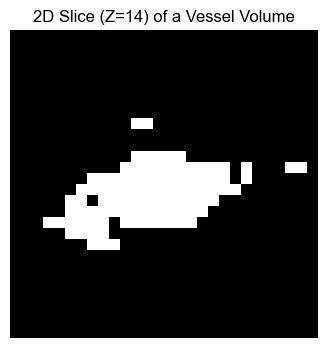

In [10]:

sample_volume = trainx_tensor[0].numpy().squeeze()

slice_index = sample_volume.shape[0] // 2 
image_slice = sample_volume[slice_index, :, :]

plt.figure(figsize=(4, 4))
plt.imshow(image_slice, cmap='gray')
plt.title(f'2D Slice (Z={slice_index}) of a Vessel Volume')
plt.axis('off')
plt.show() 


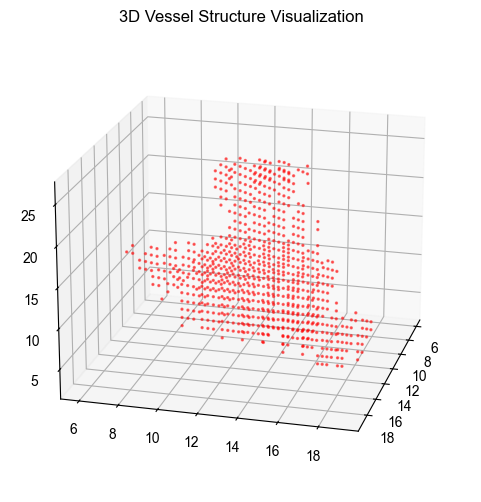

In [11]:
x, y, z = np.where(sample_volume > 0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d') 

ax.scatter(x, y, z, s=2, c='red', alpha=0.5)

ax.set_title('3D Vessel Structure Visualization')
ax.view_init(elev=20, azim=15)

plt.show()